In [1]:
import os
import re
import pandas as pd
import networkx as nx
from tqdm import tqdm
from joblib import Parallel, delayed
import gc
import glob

# 📌 Parse un fichier DOT en graphe
def parse_cfg_dot(dot_str):
    G = nx.DiGraph()
    lines = dot_str.strip().split('\n')
    for line in lines:
        line = line.strip()
        if '->' in line:
            match = re.match(r'"([^"]+)"\s*->\s*"([^"]+)"', line)
            if match:
                src, dst = match.groups()
                G.add_edge(src, dst)
        elif '[' in line and 'label =' in line:
            match = re.match(r'"([^"]+)"\s*\[label = "(.*?)"\]', line)
            if match:
                node_id, label = match.groups()
                parts = label.split(' : ')
                addr = parts[0]
                instr_type = parts[1] if len(parts) > 1 else "UNK"
                instr_text = parts[2] if len(parts) > 2 else ""
                G.add_node(node_id, addr=addr, type=instr_type, text=instr_text)
    return G

# 📌 Lire un fichier .json en graphe
def load_single_graph(file_path):
    try:
        with open(file_path, "rb") as f:
            dot_str = f.read().decode("utf-8", errors="ignore")
        if not dot_str.strip():
            return None
        G = parse_cfg_dot(dot_str)
        if G.number_of_nodes() == 0:
            return None
        return os.path.basename(file_path).replace(".json", ""), G
    except Exception as e:
        print(f"⚠️ Erreur avec {file_path}: {e}")
        return None

# 📌 Extraire des features avancées depuis un graphe
def extract_features_from_graph(graph_id, G):
    instr_types = nx.get_node_attributes(G, "type").values()
    instr_texts = nx.get_node_attributes(G, "text").values()

    instr_types_series = pd.Series(instr_types)
    instr_texts_series = pd.Series(instr_texts)

    instr_counts = instr_types_series.value_counts()
    total_instrs = len(instr_texts_series)

    def count_ratio_text(substring):
        matches = instr_texts_series.str.contains(substring, case=False, na=False)
        count = matches.sum()
        return count, count / total_instrs if total_instrs > 0 else 0

    def count_ratio_type(op):
        count = instr_counts.get(op.upper(), 0)
        return count, count / total_instrs if total_instrs > 0 else 0

    exit_nodes = [n for n in G.nodes if G.out_degree(n) == 0]
    try:
        longest_path_len = nx.dag_longest_path_length(G)
    except:
        longest_path_len = -1

    features = {
        "graph_id": graph_id,
        "nb_nodes": G.number_of_nodes(),
        "nb_edges": G.number_of_edges(),
        "nb_components": nx.number_weakly_connected_components(G),
        "nb_exit_nodes": len(exit_nodes),
        "max_path_len": longest_path_len,
        "avg_degree": float(G.number_of_edges()) / G.number_of_nodes() if G.number_of_nodes() > 0 else 0,
        "count_inst": total_instrs,
        "prop_inst": total_instrs / G.number_of_nodes() if G.number_of_nodes() > 0 else 0,
    }

    for opcode in ["CALL", "JMP", "RET", "JCC", "INVALID", "HLT", "INST"]:
        count, ratio = count_ratio_type(opcode)
        features[f"count_type_{opcode.lower()}"] = count
        features[f"prop_type_{opcode.lower()}"] = ratio

    for keyword in ["mov", "add", "xor", "cmp", "push", "pop", "lea", "sub", "loop", "syscall", "call", "jmp"]:
        count, ratio = count_ratio_text(keyword)
        features[f"count_text_{keyword}"] = count
        features[f"prop_text_{keyword}"] = ratio

    return features

# 🔍 Supprimer les .json déjà traités dans les batchs CSV existants
def clean_jsons_from_existing_csv(csv_dir, folder_path):
    print("🧹 Nettoyage des JSON déjà traités à partir des CSV existants...")
    all_csv = sorted(glob.glob(os.path.join(csv_dir, "features_batch_*.csv")))

    treated_ids = set()
    for csv_file in all_csv:
        try:
            df = pd.read_csv(csv_file, usecols=["graph_id"])
            treated_ids.update(df["graph_id"].dropna().astype(str).tolist())
        except Exception as e:
            print(f"⚠️ Erreur lecture {csv_file} : {e}")

    print(f"🔍 {len(treated_ids)} fichiers déjà extraits détectés dans les CSV.")

    deleted = 0
    for gid in treated_ids:
        json_path = os.path.join(folder_path, f"{gid}.json")
        if os.path.exists(json_path):
            try:
                os.remove(json_path)
                deleted += 1
            except Exception as e:
                print(f"⚠️ Impossible de supprimer {json_path} : {e}")
    print(f"🗑️ {deleted} fichiers JSON supprimés car déjà présents dans les CSV.")


# 📌 Pipeline batch = JSON → Graphe → Features → CSV + Suppression JSON
def extract_features_to_csv_by_batch(folder_path, csv_dir="features_batches", n_jobs=4, batch_size=500):
    os.makedirs(csv_dir, exist_ok=True)

    clean_jsons_from_existing_csv(csv_dir, folder_path)

    files = sorted([os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".json")])
    total_files = len(files)
    print(f"📂 {total_files} fichiers JSON trouvés dans {folder_path}")

    for i in range(0, total_files, batch_size):
        batch_files = files[i:i + batch_size]
        batch_num = i // batch_size + 1
        csv_path = os.path.join(csv_dir, f"features_batch_{batch_num:02}.csv")

        if os.path.exists(csv_path):
            print(f"⏭ Batch {batch_num:02} déjà existant. Skip.")
            continue

        print(f"\n📥 Batch {batch_num:02} → {len(batch_files)} fichiers à parser...")

        # Charger les graphes
        graph_results = Parallel(n_jobs=n_jobs, backend="loky")(
            delayed(load_single_graph)(file) for file in tqdm(batch_files, desc=f"Loading batch {batch_num:02}")
        )
        graph_results = [res for res in graph_results if res is not None]

        # Extraire les features
        features = Parallel(n_jobs=n_jobs)(
            delayed(extract_features_from_graph)(gid, G) for gid, G in graph_results
        )

        # Sauvegarder les features
        df = pd.DataFrame(features)
        df.to_csv(csv_path, index=False)
        print(f"✅ Features batch {batch_num:02} enregistrées dans {csv_path}")

        # Supprimer les fichiers JSON traités
        processed_files = [os.path.join(folder_path, f"{graph_id}.json") for graph_id, _ in graph_results]
        for f in processed_files:
            try:
                os.remove(f)
            except Exception as e:
                print(f"⚠️ Impossible de supprimer {f} : {e}")

        gc.collect()

    print("\n🎉 Tous les batchs disponibles ont été extraits vers CSV.")



In [3]:
# 📌 Exécution
folder_path = "folder_test_set/folder_test_set"
extract_features_to_csv_by_batch(folder_path, csv_dir="features_batches", n_jobs=-2, batch_size=322)

🧹 Nettoyage des JSON déjà traités à partir des CSV existants...
🔍 2997 fichiers déjà extraits détectés dans les CSV.
🗑️ 0 fichiers JSON supprimés car déjà présents dans les CSV.
📂 3 fichiers JSON trouvés dans folder_test_set/folder_test_set

📥 Batch 01 → 3 fichiers à parser...


Loading batch 01: 100%|██████████| 3/3 [00:00<00:00, 1499.75it/s]


✅ Features batch 01 enregistrées dans features_batches\features_batch_01.csv

🎉 Tous les batchs disponibles ont été extraits vers CSV.


In [4]:
import pandas as pd
import glob

# 📂 Chemin vers les fichiers CSV
csv_dir = "features_batches"  # ajuste si besoin

# 🔍 Récupérer tous les fichiers features_batch_XX.csv
csv_files = sorted(glob.glob(f"{csv_dir}/features_batch_*.csv"))

print(f"🔗 {len(csv_files)} fichiers trouvés.")

# 🧬 Fusionner tous les CSV dans un seul DataFrame
df_all = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)

# ✅ Supprimer les doublons potentiels
df_all = df_all.drop_duplicates(subset="graph_id")

# 🔢 Compter les graph_id distincts
print(f"📊 Nombre total de graph_id uniques : {df_all['graph_id'].nunique()}")

# 📝 Enregistrer le DataFrame fusionné
output_path = "features_batches/features_batch_15.csv"
df_all.to_csv(output_path, index=False)
#print(f"💾 Fichier fusionné enregistré sous : {output_path}")

# Aperçu rapide
print(df_all.tail())


🔗 2 fichiers trouvés.
📊 Nombre total de graph_id uniques : 22126
                                                graph_id  nb_nodes  nb_edges  \
22121  595a36b5e7bd99297d38981fe930a996a010e5af648937...      4770      7456   
22122  595b36ad86c3f233876b10eba5cbb5b08457af13b38491...      6441      8090   
22123  595bad24ccb8190d71eaba2e2071498b170123aca588d4...    167153    269283   
22124  595be12ef59d0aa82f069540d4ff415522812bc5ffc5c5...    171436    194203   
22125  5961261fd09cd94abd19fbfa9591bff4f90d58586f601c...     79903     98264   

       nb_components  nb_exit_nodes  max_path_len  avg_degree  count_inst  \
22121              7            382            -1    1.563103        4770   
22122             62            350            -1    1.256016        6441   
22123            416          19074            -1    1.610997      167153   
22124            270           4312            -1    1.132802      171436   
22125              1             12         69599    1.229791       7

In [58]:
import pandas as pd
from collections import Counter

def extract_features_from_graph(graph_id, G):
    node_types = [data.get("type", "UNK") for _, data in G.nodes(data=True)]
    type_counts = Counter(node_types)
    total_nodes = len(G.nodes)
    
    features = {
        "graph_id": graph_id,
        "nb_nodes": total_nodes,
        "nb_edges": len(G.edges),
        "avg_degree": len(G.edges) / total_nodes if total_nodes > 0 else 0,
    }
    
    # Types d'instructions fréquents à isoler
    main_types = ["CALL", "JCC", "JMP", "RET", "INST", "INVALID", "HLT"]
    
    for t in main_types:
        count = type_counts.get(t, 0)
        features[f"count_{t.lower()}"] = count
        features[f"prop_{t.lower()}"] = count / total_nodes if total_nodes > 0 else 0

    return features


In [2]:
import os
import joblib
import pandas as pd
import networkx as nx
from joblib import Parallel, delayed

# 📌 Fonction d'extraction des features depuis un graphe
def extract_features_from_graph(graph_id, G):
    instr_types = nx.get_node_attributes(G, "type").values()
    instr_counts = pd.Series(instr_types).value_counts()

    total = len(instr_types)
    def count_ratio(op):
        count = instr_counts.get(op, 0)
        return count, count / total if total > 0 else 0

    features = {
        "graph_id": graph_id,
        "nb_nodes": G.number_of_nodes(),
        "nb_edges": G.number_of_edges(),
        "avg_degree": float(G.number_of_edges()) / G.number_of_nodes() if G.number_of_nodes() > 0 else 0,
    }

    for opcode in ["call", "jmp", "ret", "jcc", "invalid", "hlt"]:
        count, ratio = count_ratio(opcode)
        features[f"count_{opcode}"] = count
        features[f"prop_{opcode}"] = ratio

    features["count_inst"] = total
    features["prop_inst"] = total / G.number_of_nodes() if G.number_of_nodes() > 0 else 0

    return features

# 📂 Charger les deux fichiers .pkl (ou plus tard, tous les batchs dynamiquement)
batch_dir = "parsed_batches"
batch1 = joblib.load(os.path.join(batch_dir, "train_graphs_batch_01.pkl"))
batch2 = joblib.load(os.path.join(batch_dir, "train_graphs_batch_02.pkl"))
all_graphs = {**batch1, **batch2}  # tu pourras y mettre tous les batchs ensuite

# ⚡ Extraction parallélisée des features
df_features = pd.DataFrame(
    Parallel(n_jobs=-1)(
        delayed(extract_features_from_graph)(gid, G) for gid, G in all_graphs.items()
    )
)

# 📊 Aperçu
print(f"{len(df_features)} graphes extraits avec features.")
df_features.head()


EOFError: 

In [60]:
df_features.tail()

,graph_id,nb_nodes,nb_edges,avg_degree,count_call,prop_call,count_jcc,prop_jcc,count_jmp,prop_jmp,count_ret,prop_ret,count_inst,prop_inst,count_invalid,prop_invalid,count_hlt,prop_hlt
95,00a385629b115390ebbca4226d4415465bf7d1c8a9c8ad...,847,1019,1.203070,0,0.000000,191,0.225502,1,0.001181,0,0.000000,636,0.750885,0,0.000000,0,0.000000
96,00a7d6c58e599ffeb883a84903a08c3c423cf9a2e8ade2...,158726,186635,1.175831,14433,0.090930,15582,0.098169,6318,0.039804,2050,0.012915,119691,0.754073,6,0.000038,49,0.000309
97,00a9a7ad7b4af99fd29bc28f8ab6999ed4c2329fa240ac...,321401,482419,1.500988,53490,0.166428,124670,0.387895,15474,0.048145,13642,0.042445,107624,0.334859,3731,0.011609,2351,0.007315
98,00ab29f665d6a710b4ee8623a9e52584a87a6140b4878d...,14665,23427,1.597477,3812,0.259939,6440,0.439141,1244,0.084828,1383,0.094306,1662,0.113331,26,0.001773,80,0.005455
99,00ad36f3cc905afcfcfb40d399c633f133b21100d59b98...,4683,7641,1.631646,2679,0.572069,555,0.118514,629,0.134316,395,0.084348,419,0.089473,0,0.000000,0,0.000000


           nb_nodes      nb_edges  avg_degree     count_call   prop_call  \
count  1.000000e+02  1.000000e+02  100.000000     100.000000  100.000000   
mean   4.836148e+04  6.593474e+04    1.463449    9313.510000    0.263035   
std    1.303448e+05  1.569648e+05    0.218752   22954.277767    0.182592   
min    1.610000e+02  2.120000e+02    0.863188       0.000000    0.000000   
25%    1.030250e+03  1.382500e+03    1.323634     224.250000    0.103141   
50%    4.794500e+03  7.724500e+03    1.555463    1547.000000    0.276283   
75%    2.352600e+04  3.794725e+04    1.604035    6399.750000    0.339172   
max    1.016644e+06  1.037825e+06    1.787734  147761.000000    0.722689   

           count_jcc    prop_jcc     count_jmp    prop_jmp     count_ret  \
count     100.000000  100.000000    100.000000  100.000000    100.000000   
mean    11174.340000    0.286622   2958.880000    0.087588   2300.940000   
std     25623.176499    0.137740   6625.083477    0.076907   5224.948386   
min        

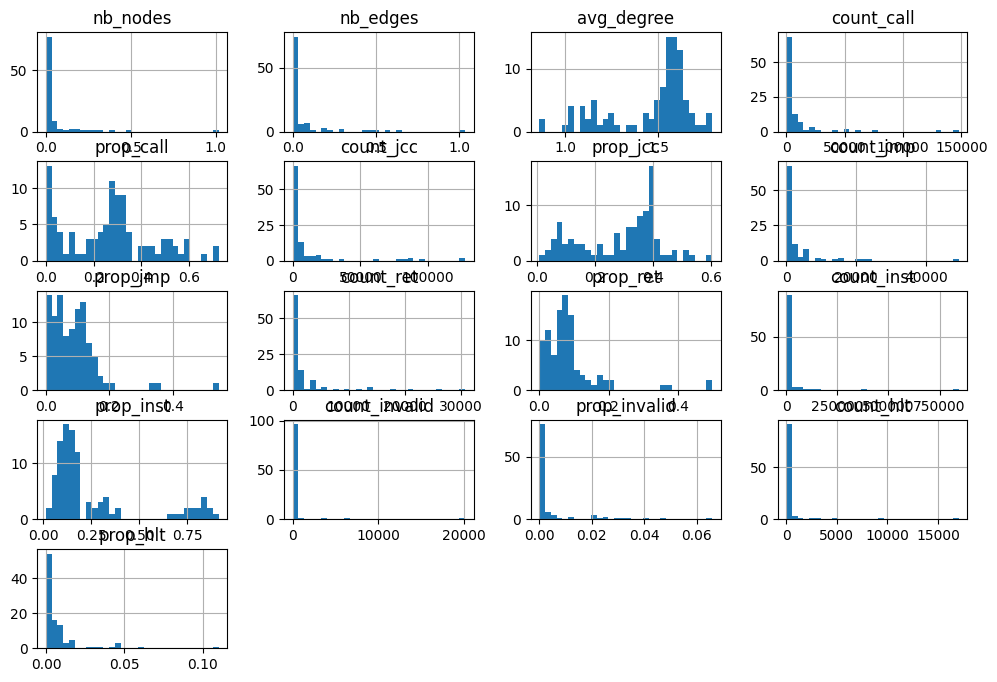

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Statistiques générales
print(df_features.describe())

# Histogrammes des principales features
df_features.hist(figsize=(12, 8), bins=30)
plt.show()



In [45]:
import pandas as pd

# 📥 1. Détection automatique du séparateur
train_metadata_path = "training_set_metadata.csv"

# Lire en essayant plusieurs séparateurs
separators = [ ";"]
for sep in separators:
    try:
        df_train_meta = pd.read_csv(train_metadata_path, sep=sep)
        print(f"✅ Chargement réussi avec séparateur : '{sep}'")
        print(df_train_meta.head(3))  # Afficher les 3 premières lignes
        break  # On s'arrête dès que ça fonctionne
    except Exception as e:
        print(f"❌ Erreur avec séparateur '{sep}':", e)

# 📌 2. Charger le fichier test normalement
test_metadata_path = "test_set_metadata_to_predict.xlsx"
df_test_meta = pd.read_excel(test_metadata_path)

# 📊 Vérifier les colonnes
print("Colonnes du training set:", df_train_meta.columns[:5])
print("Colonnes du test set:", df_test_meta.columns[:5])


✅ Chargement réussi avec séparateur : ';'
                                                name  \
0  9fbf213113ba0a18dc2642f83b1201541428fd7951d6a8...   
1  1b35c9dbf3cd9ac60015aaa6cd451c898defa6dac1ff43...   
2  bf8d307a136a936f7338c1f2eec773c4eb1c802cab77da...   

   64-bit execution via heavens gate  64bits  PEB access  \
0                                  0       1           0   
1                                  0       0           0   
2                                  0       0           0   

   accept command line arguments  access the Windows event log  \
0                              0                             0   
1                              0                             0   
2                              0                             0   

   act as TCP client  allocate RW memory  allocate RWX memory  \
0                  0                   0                    0   
1                  0                   0                    0   
2                  0            

In [46]:
df_test_meta.head()

,name,64-bit execution via heavens gate,64bits,PEB access,accept command line arguments,access the Windows event log,act as TCP client,allocate RW memory,allocate RWX memory,allocate memory,...,winzip,wise,worm,write and execute a file,write clipboard data,write file on Linux,write file on Windows,write pipe,xorcrypt,yoda
0,95ff2b3fd399984950293194a717d404bc4e9e3aa0296f...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4216c07609bb5b89f32d9b559494848a0f5411d1e2d3cf...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2518f84c015a5795bdb2597d580ab7df8e0bfa4b6543c6...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,243268c658456d9b8ec968c088c4f3c7cb976df92a4b99...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,533c09cb9b49c10494337d3eb7d2919c2c656b37f554fb...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
df_train_meta.head()

,name,64-bit execution via heavens gate,64bits,PEB access,accept command line arguments,access the Windows event log,act as TCP client,allocate RW memory,allocate RWX memory,allocate memory,...,winzip,wise,worm,write and execute a file,write clipboard data,write file on Linux,write file on Windows,write pipe,xorcrypt,yoda
0,9fbf213113ba0a18dc2642f83b1201541428fd7951d6a8...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1b35c9dbf3cd9ac60015aaa6cd451c898defa6dac1ff43...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,bf8d307a136a936f7338c1f2eec773c4eb1c802cab77da...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1e51933903f0358c0b635f863368eb15a61cd3442bc5bf...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8a6503fe68d699f8a31531c157e9da931192cd7e3ec809...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
print("Colonnes dans df_features:", df_features.columns)
print("Colonnes dans df_train_meta:", df_train_meta.columns)
print("Colonnes dans df_test_meta:", df_test_meta.columns)


Colonnes dans df_features: Index(['graph_id', 'nb_nodes', 'nb_edges', 'avg_degree', 'count_call',
       'prop_call', 'count_jcc', 'prop_jcc', 'count_jmp', 'prop_jmp',
       'count_ret', 'prop_ret', 'count_inst', 'prop_inst', 'count_invalid',
       'prop_invalid', 'count_hlt', 'prop_hlt'],
      dtype='object')
Colonnes dans df_train_meta: Index(['name', '64-bit execution via heavens gate', '64bits', 'PEB access',
       'accept command line arguments', 'access the Windows event log',
       'act as TCP client', 'allocate RW memory', 'allocate RWX memory',
       'allocate memory',
       ...
       'winzip', 'wise', 'worm', 'write and execute a file',
       'write clipboard data', 'write file on Linux', 'write file on Windows',
       'write pipe', 'xorcrypt', 'yoda'],
      dtype='object', length=454)
Colonnes dans df_test_meta: Index(['name', '64-bit execution via heavens gate', '64bits', 'PEB access',
       'accept command line arguments', 'access the Windows event log',
      

In [49]:
# 📌 2. Renommer la colonne 'name' en 'graph_id' pour aligner avec df_features
df_train_meta.rename(columns={'name': 'graph_id'}, inplace=True)
df_test_meta.rename(columns={'name': 'graph_id'}, inplace=True)

df_features["graph_id"] = df_features["graph_id"].astype(str).str.strip()
df_train_meta["graph_id"] = df_train_meta["graph_id"].astype(str).str.strip()
df_test_meta["graph_id"] = df_test_meta["graph_id"].astype(str).str.strip()

# 🔗 Fusionner df_features avec df_train_meta pour obtenir X_train et y_train
df_merged = df_features.merge(df_train_meta, on="graph_id", how="inner")

# Séparer les features (X_train) et les labels (y_train)
X_train = df_merged.drop(columns=["graph_id"] + list(df_train_meta.columns[1:]))  
y_train = df_merged[df_train_meta.columns[1:]]  

# 📌 Préparer X_test (sans labels, pour la prédiction)
df_test_merged = df_features.merge(df_test_meta, on="graph_id", how="inner")
X_test = df_test_merged.drop(columns=["graph_id"])

# 📊 Vérifier les dimensions
print(f"✅ X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"✅ X_test shape: {X_test.shape}")

# Aperçu des données
display(X_train.head(), y_train.head(), X_test.head())


✅ X_train shape: (100, 17), y_train shape: (100, 453)
✅ X_test shape: (0, 470)


,nb_nodes,nb_edges,avg_degree,count_call,prop_call,count_jcc,prop_jcc,count_jmp,prop_jmp,count_ret,prop_ret,count_inst,prop_inst,count_invalid,prop_invalid,count_hlt,prop_hlt
0,1112,1740,1.564748,270,0.242806,428,0.384892,230,0.206835,69,0.062050,114,0.102518,0,0.000000,0,0.000000
1,161,245,1.521739,6,0.037267,84,0.521739,21,0.130435,4,0.024845,44,0.273292,0,0.000000,0,0.000000
2,4607,7413,1.609073,2485,0.539397,526,0.114174,641,0.139136,470,0.102019,437,0.094856,0,0.000000,0,0.000000
3,102070,182474,1.787734,60104,0.588851,24487,0.239904,4938,0.048379,3941,0.038611,8320,0.081513,0,0.000000,245,0.002400
4,42349,64677,1.527238,13625,0.321731,13004,0.307067,3474,0.082033,3590,0.084772,7551,0.178304,932,0.022008,118,0.002786


,64-bit execution via heavens gate,64bits,PEB access,accept command line arguments,access the Windows event log,act as TCP client,allocate RW memory,allocate RWX memory,allocate memory,allocate or change RW memory,...,winzip,wise,worm,write and execute a file,write clipboard data,write file on Linux,write file on Windows,write pipe,xorcrypt,yoda
0,0,0,0,1,0,0,1,1,1,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,nb_nodes,nb_edges,avg_degree,count_call,prop_call,count_jcc,prop_jcc,count_jmp,prop_jmp,count_ret,...,winzip,wise,worm,write and execute a file,write clipboard data,write file on Linux,write file on Windows,write pipe,xorcrypt,yoda


In [51]:
df_merged.head()

,graph_id,nb_nodes,nb_edges,avg_degree,count_call,prop_call,count_jcc,prop_jcc,count_jmp,prop_jmp,...,winzip,wise,worm,write and execute a file,write clipboard data,write file on Linux,write file on Windows,write pipe,xorcrypt,yoda
0,000288eb820d08011f1f5a379d3ac38e3a4bf679777c2f...,1112,1740,1.564748,270,0.242806,428,0.384892,230,0.206835,...,0,0,0,0,0,0,1,0,0,0
1,000299f0baee15daa295b45083f32f0183c25948efdb88...,161,245,1.521739,6,0.037267,84,0.521739,21,0.130435,...,0,0,0,0,0,0,0,0,0,0
2,0006f473314630a3a3089e4cf00e34b055d24dc8f82717...,4607,7413,1.609073,2485,0.539397,526,0.114174,641,0.139136,...,0,0,0,0,0,0,0,0,0,0
3,00090d289035749bdd0a25ad1990be32b12e3d1ae03bc5...,102070,182474,1.787734,60104,0.588851,24487,0.239904,4938,0.048379,...,0,0,0,0,0,0,1,0,0,0
4,000a3c574c875d19538eb58a9aca407f3a7db5f7d561b4...,42349,64677,1.527238,13625,0.321731,13004,0.307067,3474,0.082033,...,0,0,0,0,0,0,0,0,0,0


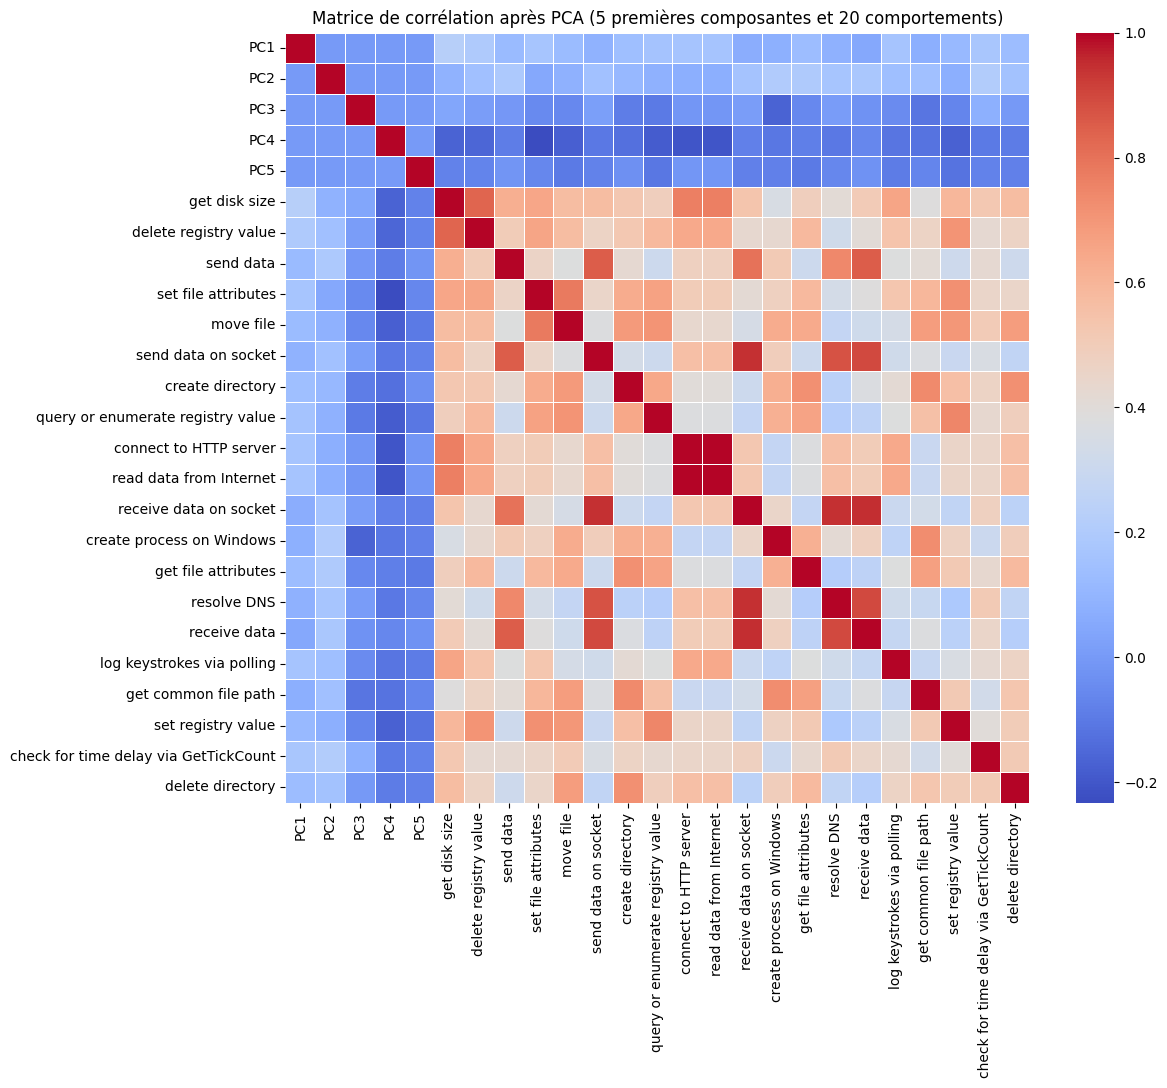

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# 📌 Paramètres
n_components = 5  # Nombre de composantes principales à afficher
n_top_labels = 20  # Nombre de comportements les plus corrélés à afficher

# Séparer les features et les labels
features = df_merged.drop(columns=["graph_id"] + list(df_train_meta.columns[1:]))  # Features uniquement
labels = df_merged[df_train_meta.columns[1:]]  # Labels (comportements)

# Centrer et réduire les features avant PCA
features_scaled = (features - features.mean()) / features.std()

# Appliquer la PCA
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(features_scaled)
df_pca = pd.DataFrame(principal_components, columns=[f"PC{i+1}" for i in range(n_components)])

# Ajouter les labels pour voir les corrélations
df_pca = pd.concat([df_pca, labels.reset_index(drop=True)], axis=1)

# Calculer la matrice de corrélation
df_corr = df_pca.corr()

# Sélectionner les labels les plus corrélés avec les PC
top_labels = df_corr.iloc[:, n_components:].abs().sum().sort_values(ascending=False).head(n_top_labels).index
df_corr_filtered = df_corr.loc[list(df_corr.columns[:n_components]) + list(top_labels), list(df_corr.columns[:n_components]) + list(top_labels)]

# 📊 Afficher la nouvelle matrice de corrélation
plt.figure(figsize=(12, 10))
sns.heatmap(df_corr_filtered, annot=False, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title(f"Matrice de corrélation après PCA ({n_components} premières composantes et {n_top_labels} comportements)")
plt.show()
